<a href="https://colab.research.google.com/github/kodiakpony/datakit-housing-fall-2024/blob/main/DataKindChallenge3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Intro and Background


*   DataKind Housing challenge
*   Challenge 3, "Getting Started" analysis
*   Used EODataScape data (with different names than data dictionary, augmented by the following other datasets (for population, and visualization)
* Add links to datasets/data dictionaries
* note geoids 11 digit STATE+COUNTY+TRACTID. add link to geoids page
* explain what an CDFI investment area is
*   Also wanted to use CDFI dataset to get more granular info, but it is using 2010 census ids. Is still very interesting. S  ee separate analysis
*   Analysis done in Google Colab, using Pandas, Seaborn.  
* Also have a Folium map (in this doc or elsewhere?

Note that there are already existing tools that let you look up an address and explore an interactive map to get information about a census tract including which government programs it belongs to??.  In particular, the [CDFI public viewer](https://www.google.com/url?q=https%3A%2F%2Fcimsprodprep.cdfifund.gov%2FCIMS4%2Fapps%2Fpn-cdfi%2Findex.aspx%23%3Fentity%3DSTATE%2C12%26center%3D-83.804605%2C27.748685%26level%3D7%26tool%3Dresult%26visible%3DCT_2020_CDFI%2CSTATE), which is just one of the mapping tools provided by the [CDFI Fund CIMS Mapping Tool](https://www.cdfifund.gov/cims). Just enter and address or select a census tract from the map and click on "details" to get a bunch of information about that tract including which HUD programs it belongs to??. There are also different map layers that can be enabled.

* Key takeaways??
* TODO: also create README in GitHub,
        make plotly scatterplots versin
        CDFI dataset writeup
        check in messy writeup
        write reflections/newbie notes



## Setup

*Import libraries, read in datasets*


We import:

*   Python Pandas for data manipulation
*   Seaborn (built on top of Matplotlib) for most of our visualizations
*   matplotlib_venn for making Venn diagrams
*   zipfile, requests, io for fetching and reading the datasets


In [49]:
# import libraries

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn2_circles,venn3, venn3_circles, layout
import seaborn as sns
import zipfile
import requests, io

#import numpy as np
#import geopandas as gpd
#import folium
# from mpl_toolkits.axes_grid1 import make_axes_locatable

Next we read in the [1.1 version of DataKind's Fall 2024 housing dataset](https://github.com/datakind/datakit-housing-fall-2024/releases/tag/v1.1), which was provided by DataKind for use in the DataKit event.

Version 1.1 has different column names than the 1.0 version, and so is not consistent with the EODatascape data dictionary. It is generally obvious from the column names which ones they correspond to. (Version 1.0 had incomplete data -- less than 2000 of Florida's >5000 census tracts)

We rename some of the columns to be consistent with v1.0 naming conventions, but not all of them.

We also do a bit of data cleanup, dropping a small number of census tracts with bogus values, and adding some new columns that will be convenient for making visualizations.


In [50]:
# Read DataKind EODataScape housing dataset into Panda dataframe df

version=1.1
url = f"https://github.com/datakind/datakit-housing-fall-2024/releases/download/v{version}/housing-data.zip"
filename = "housing-data/FL/data_1-FL.csv"

r = requests.get(url)

with zipfile.ZipFile(io.BytesIO(r.content)) as myzip:
    with myzip.open(filename) as myfile:
        df = pd.read_csv(myfile)

# rename some columns because the original dataset used different names than the current one and I don't want to change everything
# don't do renaming if using the v1.0 dataset
if(version==1.1):
  column_renames={
      "hud_opportunity_zones" : "opzone",
      "cdfi_fund_invest_areas" : "investment_areas",
      "lihtc_qualified_tracts" : "qct",
      "cdfi_fund_economic_distress" : "economic_distress_pop_agg",
      "county" : "county_name",
      "county_fips_code" : "county",
  }
  df=df.rename(columns=column_renames)

# add a boolean column for whether a census tract has non-negligible CDFI lending
df["has_cdfi_lending"]=df.total_cdfi_lending.apply(lambda x: x>10000)

# make "cdfi_fund_invest_areas" a clone of "investment_areas"
df["cdfi_fund_invest_areas"]=df.investment_areas

# change "investment_areas" from YES/NO to 1/0,
df["investment_areas"]=df.investment_areas.apply(lambda x: 1 if x=="YES" else 0)

#  add a column indicating which set of government programs a Census tract belongs to (CDFI Investment Areas, HUD Qualified Census Tract, HUD Opportunity Zone)
#  values are like "101", "010" etc indicating membership in investment_areas, opzone, and qct by digit
df["venn_key"]=df.apply(lambda x: str(x.investment_areas)[0]+str(x.opzone)[0]+str(x.qct)[0],axis=1)

# make a human friendly versions of that column, combining the rare values, to be used for pie charts and histograms
df["overlap_label"]=df.venn_key.map({
    "000":"none",
    "100":"ia",
    "101":"ia+qct",
    "111":"all",
    "110":"ia+op",
    "011":"other",
    "010":"other",
    "001":"other"
})

df["overlap_label2"]=df.venn_key.map({
    "000":"none",
    "100":"ia only",
    "101":"hud",
    "111":"hud",
    "110":"hud",
    "011":"hud",
    "010":"hud",
    "001":"hud"
})

# add a similar column combinining investment_areas, has_cdfi_lending, and economic_distress
df["venn_ia_hl_ed"]=df.apply(lambda x: str(x.investment_areas)[0]+str("1" if x.has_cdfi_lending else "0")[0]+str("1" if x.economic_distress_pop_agg=="YES" else "0")[0],axis=1)

# drop rows for which total_cdfi_lending or num_mortgages_origin is not defined
display(f"dropping rows with missing total_cdfi_lending: {df.total_cdfi_lending.isna().sum()}")
display(f"dropping rows with missing num_mortgages_origin: {df.num_mortgages_origin.isna().sum()}")
df.dropna(subset=["num_mortgages_origin","total_cdfi_lending"],inplace=True)

# set percentile columns for cdfi lending and num mortages originated
df["pctile_cdfi_lending_fl"]=df.total_cdfi_lending.rank(pct=True)*100
df["pctile_mortgages_origin_fl"]=df.num_mortgages_origin.rank(pct=True)*100

df.head().T

'dropping rows with missing total_cdfi_lending: 124'

'dropping rows with missing num_mortgages_origin: 83'

,0,1,2,3,4
geoid,12001000600,12001000809,12001001100,12001001202,12001001519
geoid_year,2020,2020,2020,2020,2020
state,Florida,Florida,Florida,Florida,Florida
county_name,Alachua County,Alachua County,Alachua County,Alachua County,Alachua County
state_fips_code,12,12,12,12,12
...,...,...,...,...,...
overlap_label,all,ia+qct,none,none,ia+qct
overlap_label2,hud,hud,none,none,hud
venn_ia_hl_ed,111,101,010,010,111
pctile_cdfi_lending_fl,17.38176,0.967871,20.933945,99.620834,12.133307


Next we read in a dataset downloaded from census.gov and stored in Github which contains the population and number of households per census tract, and merge it with the DataKind dataset.

TODO: add more info about data source was it CensusReporter? data.census.gov?

This results in a few more census tracts being dropped, but not many.

In [51]:
# read in the dataset downloaded from census.gov, which has population and number of households per census tract

url="https://raw.githubusercontent.com/datakind/datakit-housing-fall-2024/refs/heads/main/challenge-3/FL/DECENNIALDP2020.DP1_2024-10-12T222820/DECENNIALDP2020.DP1-Data.csv"

population_df_columns={
    "GEO_ID":"full_geoid",
    "NAME":"full_name",
    "DP1_0001C":"total_population",
    "DP1_0132C":"total_households"
}

# the first two rows of the dataset are column descriptions and Florida-wide totals. Ignore them, as well as unneeded columns in dataframe
# need to set low_memory=False to avoid a warning because columns have mixed datatypes because of the first two rows being special
dfpop = pd.read_csv(url,low_memory=False).loc[2:,[*population_df_columns]].rename(columns=population_df_columns)

# make population and households columns numeric, now we've dropped the descriptions row
dfpop.total_population=dfpop.total_population.astype(int)
dfpop.total_households=dfpop.total_households.astype(int)

# the dataset uses fully qualified geoids that encode country, with format:
# 1400000US12001000201
# we just want the last 11 digits for consistency with other dataset
dfpop["geoid"]=dfpop["full_geoid"].apply(lambda x: x.split("US")[1]).astype(int)

display("census population dataset: ",dfpop.head())

# merge into main dataframe
display("merging population totals data into main dataframe")
display("dfpop shape:",dfpop.shape, "df shape: ",df.shape)
df=df.merge(dfpop,on="geoid",how="left")
display("merged df shape: ", df.shape)

'census population dataset: '

,full_geoid,full_name,total_population,total_households,geoid
2,1400000US12001000201,Census Tract 2.01; Alachua County; Florida,4348,1711,12001000201
3,1400000US12001000202,Census Tract 2.02; Alachua County; Florida,4782,1695,12001000202
4,1400000US12001000301,Census Tract 3.01; Alachua County; Florida,3384,1808,12001000301
5,1400000US12001000302,Census Tract 3.02; Alachua County; Florida,2644,1257,12001000302
6,1400000US12001000400,Census Tract 4; Alachua County; Florida,5330,2117,12001000400


'merging population totals data into main dataframe'

'dfpop shape:'

(5160, 5)

'df shape: '

(5011, 392)

'merged df shape: '

(5011, 396)

## Number of Mortgages and Total CDFI Lending

This section looks at the first [Challenge 3 Getting Started](https://github.com/datakind/datakit-housing-fall-2024/discussions/3) bullet item:


> *Create an understanding of initial funding distributions - where CDFI lending is reported and the number of mortgages originated at a Census tract level using EODatascape variables Total CDFI Lending Reported (CDFI Fund Transaction Level Report) and Number of Mortgages Originated (HMDA LAR).*



In the v1.1 dataset, these are columns **total_cdfi_lending** and **num_mortgages_origin**.  They correspond to columns *loan_amount*
 and *num_mortgage_originated* in the v1.0 dataset and DataKind's [EODataScape data dictionary](https://eodatascape.datakind.org/data-dictionary)

*loan_amount* is Total CDFI Lending Reported (in the [FY2021 CDFI Fund Transaction Level Report](https://www.cdfifund.gov/sites/cdfi/files/2023-07/FY2021_Data_Documentation_Instruction.zip)). The data source is U.S. Department of the Treasury Community Development Financial Institutions Fund (CDFI Fund), and column description is "original loan/investment amount".

*num_mortgage_originated* has description "number of mortgages reported as originated (HMDA LAR)" and is 2023 data from the [FFIEC Modified Loan/Application Register (LAR)](https://ffiec.cfpb.gov/data-publication/modified-lar/2023) set up as part of the Home Mortgage Disclosure Act (HDMA).

Some important things to understand about this data that I hadn't realized at first and can cause confusion:

1.  *num_mortgages_origin* includes all mortgages that get originated in a census tract, regardless of whether there was any CDFI or government funding assistance.

2. CDFI lending doesn't only go to CDFI investment areas. CDFIs need to give a certain percentage of their funding (40%? 60%?) to recipients who are either in a CDFI investment area or are outside of an investment area but themselves belong to that CDFI's target constituency based on their income, race etc.

3.  CDFI lending isn't just to help people buy homes. A large chunk of CDFI lending goes to businesses and construction, and CDFI also provides microloans. *total_cdfi_lending/loan_amount* includes all of these things together. (They are broken out separately in the CDFI Fund Transaction Level Report - the source dataset for *total_cdfi_lending*).

4.  The CDFI Fund Transaction Level Report (used for *total_cdfi_lending*) uses 2010 census tract geoids, but EODataScape uses 2020 census tract ids, so sadly it isn't easy to merge in.

5. There must have been some geoid remapping done to get *total_cdfi_lending/loan amount* in EODataScape given that the source data uses 2010 census ids. The sum of *total_cdfi_lending* in the DataKind dataset is significantly higher than in the source dataset, which makes me think that the remapping was done by adding together the loan_amount values of all 2010 census tract ids that overlap a given 2020 census tract id. I haven't followed up on this, but I suspect this may skew the *total_cdfi_lending* values quite a bit. It would be really nice to have CDFI data based on 2020 census ids but there does not appear to be any available.

6. The CDFI Fund Transaction Level Report has lots of useful information, including which funding was for home purchases vs businesses vs construction, the size of individual loans, demographics about the loan recipient (income level, race etc), and the CDFI that originated the loan. I dug into the data quite a bit before noticing that it uses 2010 census ids. It's in another Google Colab doc. I had been hoping to use it to get total CDFI home mortgage lending as well as the number of CDFI funded home mortgages per census tract, which seems like what we really want for some of these analyses.

TODO: add link to CDFI colab


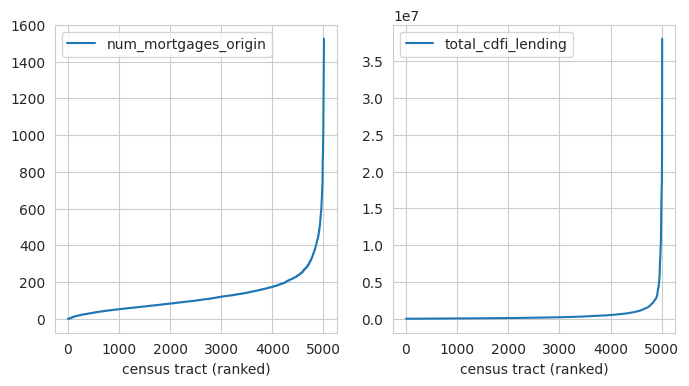

In [14]:
# Create subplots
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(8,4))

df.num_mortgages_origin.sort_values(ascending=True).reset_index().plot(y="num_mortgages_origin",ax=axes[0],xlabel="census tract (ranked)")

df.total_cdfi_lending.sort_values(ascending=True).reset_index().plot(y="total_cdfi_lending",ax=axes[1],xlabel="census tract (ranked)")

plt.show()

**Discussion**

Above, we plot *num_mortgages_origin* and *total_cdfi_lending* after sorting census tracts by those variables. You can see that we have about 5000 census tracts total.

The plots let us see the extreme tail values for each of these variables. e.g over 4000 census tracts have < 200 mortgages originated but some have over 1400. For total CDFI lending the tail is even more extreme, with over 4500 having less than \$2 million in spending but some having over \$35 million.

This means that care must be taken when looking at how total CDFI lending and mortgages are apportioned amongst different categories of census tracts, since a small percentage of census tracts can dominate the totals and skew the results significantly. Rather than the sum of CDFI lending across a category, it may be more useful to look at histograms, scatterplots or percentiles. Or to exclude the outlier values from the aggregation.

The query below shows that 27% of total CDFI lending for the state of Florida goes to 1% of census tracts (and 7% of mortgages are originated in 1% of census tracts)



In [18]:
q=df.loc[:,["num_mortgages_origin","total_cdfi_lending"]].quantile([0.99])

percent_cdfi_funding_in_top_1_percent = df.total_cdfi_lending[df.total_cdfi_lending>=q.loc[0.99,"total_cdfi_lending"]].sum()*100/df.total_cdfi_lending.sum()

percent_mortgages_in_top_1_percent = df.num_mortgages_origin[df.num_mortgages_origin>=q.loc[0.99,"num_mortgages_origin"]].sum()*100/df.num_mortgages_origin.sum()

display(
    "percentiles:",q,
    "percentage of total contained in the top 1% of census tracts:",
    f"num_mortgages: {percent_mortgages_in_top_1_percent:0.1f}%",
    f"CDFI funding: {percent_cdfi_funding_in_top_1_percent:0.1f}%"
    )

'percentiles:'

,num_mortgages_origin,total_cdfi_lending
0.99,604.7,6.064774e+06


'percentage of total contained in the top 1% of census tracts:'

'num_mortgages: 7.2%'

'CDFI funding: 27.4%'

I am curious about what is causing 1% of census tracts to get over a quarter of all CDFI lending. There may be some skew in the data due to 2010 census ids, but that isn't the main culprit. I saw similarly large values in the source CDFI dataset.

My investigations there found a single commercial real estate loan for \$37 million in May 2021 that accounts almost the entire lending for the maximum lending census tract. There were also home loans over \$1 million each in other places that can quickly add up.

The source CDFI dataset lists an "org_id" associated with the CDFI that provided the loan, but I couldn't find a way to tie it back to the name or location of the organization itself. That said, I've heard that many CDFIs are regional, only serving a few counties.

So next we look at the county distribution of the top 1% of CDFI lending census tracts, to see if it gives us any clues.


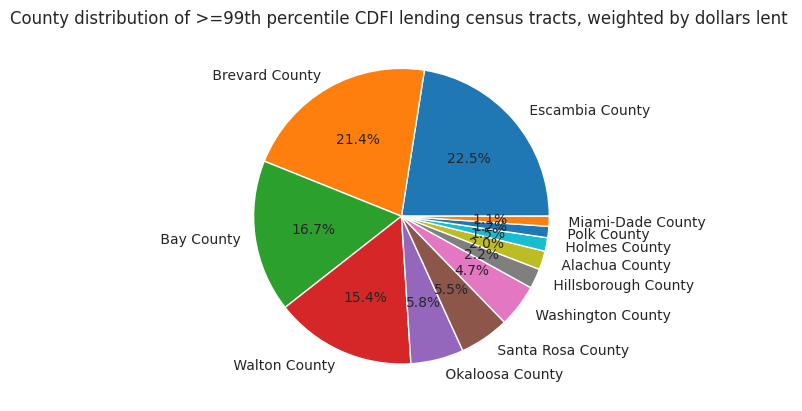

99th percentile census tract CDFI lending is $6.1 million
These tracts get 27.4% of overall CDFI lending for the state of Florida


In [22]:
top_pct_cutoff=df.loc[:,"total_cdfi_lending"].quantile([0.99]).loc[0.99]
cdf=df.loc[df.total_cdfi_lending>=top_pct_cutoff,["total_population","total_cdfi_lending","county_name"]].groupby("county_name").sum().sort_values("total_cdfi_lending",ascending=False)

fig, ax = plt.subplots()

plt.pie(cdf.total_cdfi_lending,autopct='%1.1f%%',labels=cdf.index)
plt.title("County distribution of >=99th percentile CDFI lending census tracts, weighted by dollars lent ")
plt.show()
print(f"99th percentile census tract CDFI lending is ${top_pct_cutoff/1000000:.1f} million")
print(f"These tracts get {percent_cdfi_funding_in_top_1_percent:0.1f}% of overall CDFI lending for the state of Florida")

We see that four counties get the bulk of this top 1% lending (and so account for >20% of total CDFI lending just from their top 1% census tracts alone).

I found [list of Florida CDFIs](https://www.cdfi.org/wp-content/uploads/2013/02/Florida-1.pdf) to see if any of them were in these "whale" counties, but need to investigate more.

Here are the major cities in these top counties:

*   Escambia County - Pensacola
*   Brevard County - not sure, but is just east of Orlando
*   Bay County - Panama City
*   Walton County - Freeport

Ecambia, Bay, and Walton counties are right by each other in westernmost part of the Florida panhandle, so may be served by the same CDFI?  I did see a CDFI listed in Pensacola - Community Enterprise Investments Inc. Community South Credit Union, Chipley is also nearby. There are several CDFIs Tallahassee, which is still on the panhandle but a bit further away.

Let's look at just the top 5 lending census tracts..







In [27]:
display(df.sort_values("total_cdfi_lending",ascending=False).loc[:,["geoid","full_name","total_cdfi_lending"]].head(5))

,geoid,full_name,total_cdfi_lending
1536,12033003400,Census Tract 34; Escambia County; Florida,38078471.0
1527,12033000802,Census Tract 8.02; Escambia County; Florida,35532094.2
2795,12033000801,Census Tract 8.01; Escambia County; Florida,23688062.8
5009,12133970103,Census Tract 9701.03; Washington County; Florida,21679220.0
3813,12009063105,Census Tract 631.05; Brevard County; Florida,20044137.0


We see that the top 3 are all in Escambia County, home to [Pensacola - Community Enterprise Investments Inc](https://ceii-cdc.org/).  Their web site mostly talks about affordable housing and busines microloans. Perhaps these large loans are going towards large multifamily housing developments? (Loans tagged as commercial can include mixed commercial/residential use developments) Perhaps there had been a recent hurricane?

Anyway, all of this is a bit of a diversion from what I'm supposed to be focusing on, but it did get me wondering how fair the allocation of CDFI funding is across counties (not just looking at the top 1% lending census tracts).

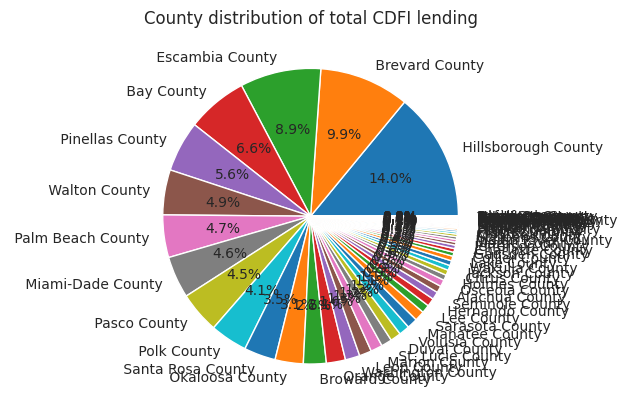

In [28]:
top_pct_cutoff=df.loc[:,"total_cdfi_lending"].quantile([0.99]).loc[0.99]
cdf=df.loc[:,["total_population","total_cdfi_lending","county_name"]].groupby("county_name").sum().sort_values("total_cdfi_lending",ascending=False)

fig, ax = plt.subplots()

plt.pie(cdf.total_cdfi_lending,autopct='%1.1f%%',labels=cdf.index)
plt.title("County distribution of total CDFI lending")
plt.show()

The above chart isn't pretty, but it shows that lots of counties get a good amount of CDFI lending. Escambia, Brevard, Bay and Walton (which dominated the top 1%) are 4 of the top 6 here.

Interestingly, Hillsborough County gets the most CDFI lending yet had only 2% of the top 1% census tracts. Tampa is in Hillsborough County, and [has several CDFIs](https://www.cdfi.org/wp-content/uploads/2013/02/Florida-1.pdf) (GTE Federal Credit Union, Suncoast Credit Union, Tampa Bay Black Business Investment Corp, Tampa Bay Federal Credit Union)

The other thing I was wondering about regarding *num_mortgages_origin* and *total_cdfi_lending* is if the large values for a small fraction of census tracts have anything to do with population.

It makes intuitive sense that census tracts with larger numbers of households would have more mortgages and potentially more CDFI funding (depending on need).



So let's look at a scatter plot of number of households vs number of originated mortages per census tract. Blue dots indicate census tracts that are CDFI Fund Investment Areas. Orange dots are not.

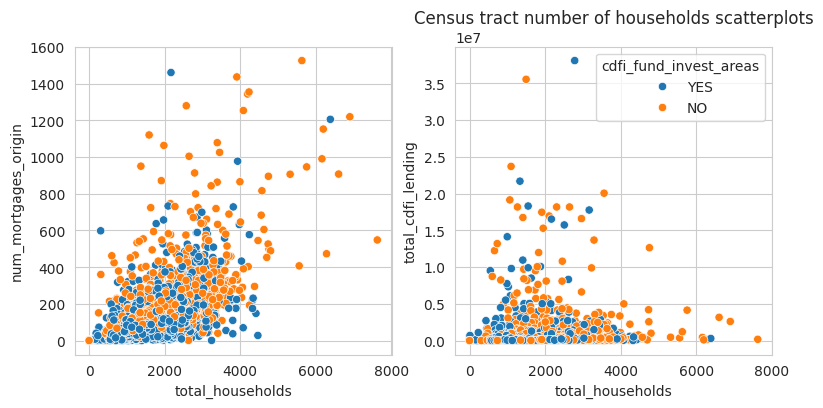

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))

sns.scatterplot(data=df,x="total_households",y="num_mortgages_origin",hue="cdfi_fund_invest_areas",ax=axes[0],legend=False)

sns.scatterplot(data=df,x="total_households",y="total_cdfi_lending",hue="cdfi_fund_invest_areas",ax=axes[1])
plt.title("Census tract number of households scatterplots")
plt.show()


Differing census tracts populations do not appear to be driving the high tail values for number of mortgages or CDFI lending.

Above we some assocation between number of households and number of mortgages, but there are plenty of outliers with moderate numbers of households but large numbers of mortgages. The tracts with > 800 mortgages orginated are overwhelmingly not CDFI fund investment areas.

For CDFI lending, the results are even more extreme. Interestingly, the large values for CDFI lending are almost entirely in tracts with < 4000 households, and are a mix of CDFI fund investment areas and non-investment areas. The census tracts with > 4000 households tend not to be CDFI fund investment areas and have low to modest amounts of CDFI lending.  

It's interesting that CDFI fund investment area census tracts don't seem to get more funding than non-investment area census tracts (i.e. there are plenty of both orange and blue dots as total_cdfi_lending increases). I was puzzled by that until I learned that funding can go to qualified individuals/businesses in any census tract, and that only a certain percentage of CDFI funding needs to go to the target population.

The other thing that occurred to me is that for CDFI lending, total_households may be less relevant than total poor households (or whatever identfies a target population for a CDFI). We will look at socioeconomic data later. But the blue dots indicate investment areas, which are high need areas, and they don't show CDFI lending increasing as number of households increases either. In fact they show the opposite.

I went ahead and snuck a peek at total poor households (total households multiplied by percent below poverty line) below.




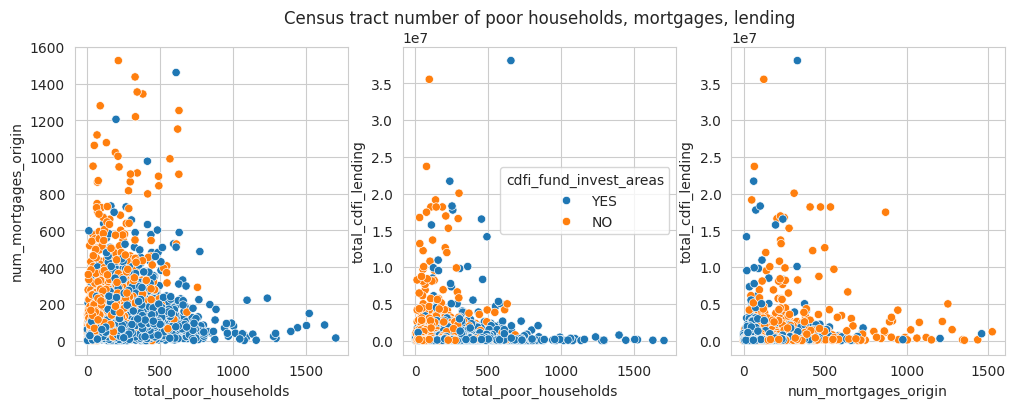

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

tdf=df.loc[df.pov_pct_est>0,["total_households","pov_pct_est","cdfi_fund_invest_areas","total_cdfi_lending","num_mortgages_origin"]]
tdf["total_poor_households"]=tdf.total_households*tdf.pov_pct_est/100
sns.scatterplot(tdf,x="total_poor_households",y="num_mortgages_origin",hue="cdfi_fund_invest_areas",ax=axes[0],legend=False)
sns.scatterplot(tdf,x="total_poor_households",y="total_cdfi_lending",hue="cdfi_fund_invest_areas",ax=axes[1])
axes[1].set_title("Census tract number of poor households, mortgages, lending")
sns.scatterplot(df,x="num_mortgages_origin",y="total_cdfi_lending",hue="cdfi_fund_invest_areas",ax=axes[2],legend=False)
plt.show()

In the left two plots, we can see clearly that census tracts with larger numbers of poor households (e.g. > 750) tend to be CDFI investment areas (i.e. blue dots) and have much lower amounts of CDFI lending and number of mortgages than those with fewer poor households. There are CDFI investment areas with large numbers of mortgages, and CDFI investment areas with large amounts of CDFI lending, but they are census tracts with smaller numbers of poor households in them.

The rightmost plot compares mortgages and CDFI lending directly. Interestingly, there are investment areas with large amounts of CDFI lending, and ones with large numbers of mortgages, but they are mutually exclusive. We don't see investment areas with large amounts of both.  

One would hope that CDFI lending would increase the number of mortgages in investment areas! But as we saw earlier, the census tracts with large amounts of CDFI lending may be dominated by real estate and commercial investments. What we really want to see here is amounts of CDFI home mortgage lending and number of CDFI assisted mortgages initiated.  

There may also be some data skew in the CDFI lending numbers due to the 2010 census ids in the source dataset.

Regardless, it looks like census tracts with larger numbers of poor households are currently underserved by CDFI lending. We will see later that many of them are part of other government housing programs such as HUD opportunity zones or HUD qualified census tracts.

Let's start looking at those other government programs now.





## Government housing programs

This section explores the relationship between the Dept of Treasury [CDFI Fund Investment Areas](https://home.treasury.gov/policy-issues/small-business-programs/state-small-business-credit-initiative-ssbci/2021-ssbci/cdfi-fund-investment-areas) and census tracts served by other government programs, namely the HUD [Low Income Housing Tax Credit (LIHTC) program](https://www.huduser.gov/portal/datasets/qct.html) Qualified Census Tracts and the HUD [Opportunity Zones Program](https://opportunityzones.hud.gov/) Census Tracts.

It focuses on overlap between these programs and their relationship to mortgages and CDFI lending.

First, let's look at a Venn diagram of CDFI investment area census tracts relative to other CDFI census tract data..




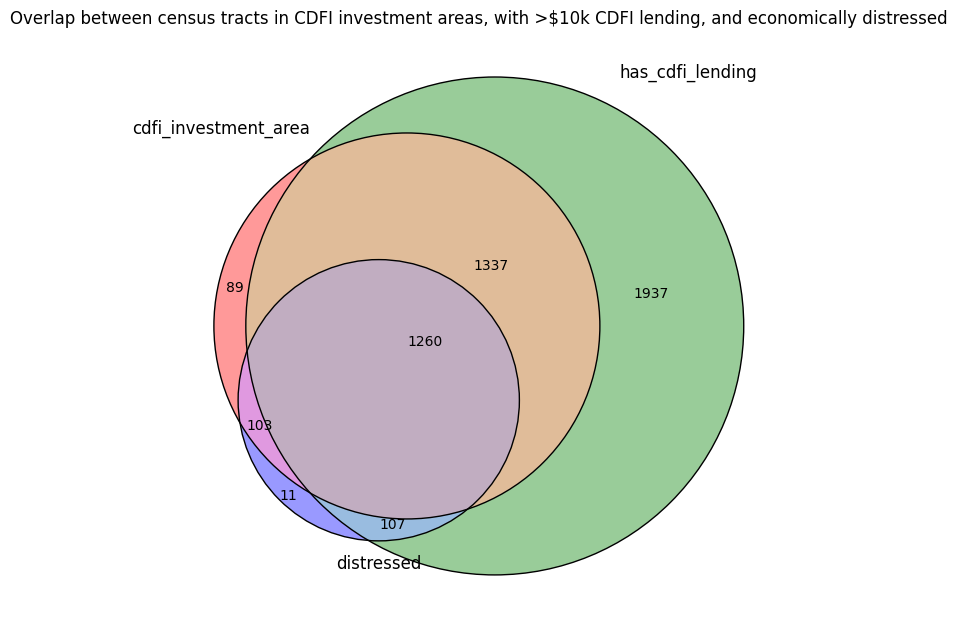

'\nvenn3(\n    df.loc[:,["venn_key2","total_population"]].groupby("venn_key2").sum()["total_population"].to_dict(),\n    subset_label_formatter=lambda x: f"{x/1000:,.1f}k",\n    set_labels=labels,\n    ax=axes[1]\n)\n'

In [ ]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
labels=["cdfi_investment_area","has_cdfi_lending","distressed"]
venn3(
    df.loc[:,["venn_ia_hl_ed","geoid"]].groupby("venn_ia_hl_ed").count()["geoid"].to_dict(),
    set_labels=labels,
#    ax=axes[0]
)

venn3_circles(
    df.loc[:,["venn_ia_hl_ed","geoid"]].groupby("venn_ia_hl_ed").count()["geoid"].to_dict(),
    linewidth=1
)

plt.title("Overlap between census tracts in CDFI investment areas, with >\$10k CDFI lending, and economically distressed")
plt.show()
"""
venn3(
    df.loc[:,["venn_key2","total_population"]].groupby("venn_key2").sum()["total_population"].to_dict(),
    subset_label_formatter=lambda x: f"{x/1000:,.1f}k",
    set_labels=labels,
    ax=axes[1]
)
"""

As mentioned previously, CDFI's need to lend a certain percentage of their funds to their target populations, meaning either individuals who meet certain demographic criteria or live in a census tract designated as a CDFI investment area. Thus, many census tracts get CDFI lending without being investment areas.

*has_cdfi_lending* - above includes all census tracts that have at least \$10,000 in CDFI lending. That number was chosen somewhat arbitrarily, but is meant to ignore census tracts that only have tiny microloans. This comes from 2021 data, and as mentioned before the source data uses 2010 census tract ids.

*cdfi_investment_area* - is census tracts that are designated as investment areas. There are many factors that go into this including poverty, population loss, unemployment rate. This comes from 2021 data.

*distressed* - is census tracts marked by columns "cdfi_fund_economic_distress" (v1.1) or "economic_distress_pop_agg" (v1.0) in the DataKind dataset, and called "area_of_economic_distress" in the DataKind eodatascape data dicionary. It also has [a lot of factors that go into it](https://eodatascape.datakind.org/data-dictionary), but luckily it is the first entry in the data dictionary so is easy to find the description. A major factor is at least 20% of households being in poverty. This comes from 2024 data.

In the above Venn diagram, we see that these sets of census tracts are largely nested - most "distressed" tracts are in "cdfi_investment_areas" and most "cdfi_investment_areas" are in "has_cdfi_lending".  This is as we'd hope.

That said, they don't overlap perfectly.  There are 103 census tracts that are distressed and in CDFI investment areas but have negligible CDFI lending.

Let's look at the 11 census tracts that are distressed but have < \$10,000 CDFI lending and are not in investment areas to see if we can figure out what is going on.


In [52]:
display(df[df.venn_ia_hl_ed == "001"].loc[:,[
    "geoid","county_name","cdfi_fund_invest_areas","opzone","qct","total_population","total_cdfi_lending"]
                                  ].sort_values("county_name"))

,geoid,county_name,cdfi_fund_invest_areas,opzone,qct,total_population,total_cdfi_lending
1309,12011031102,Broward County,NO,0,0,3769,2861.000000
1311,12011040101,Broward County,NO,0,0,1256,2029.715902
1313,12011040506,Broward County,NO,0,0,2201,7912.621990
3855,12011020211,Broward County,NO,0,1,2419,7031.000000
3987,12021010111,Collier County,NO,0,0,2326,4134.666667
4001,12021010520,Collier County,NO,0,0,2151,322.222691
3030,12073001803,Leon County,NO,0,0,811,2669.813384
637,12086006706,Miami-Dade County,NO,0,0,2404,1247.000000
1893,12086007607,Miami-Dade County,NO,0,0,2500,4322.500000
3290,12087971900,Monroe County,NO,0,0,7028,3261.000000



The [CDFI public viewer](https://cimsprodprep.cdfifund.gov/CIMS4/apps/pn-cdfi/index.aspx#?entity=CT_2020_CDFI,12011031102&center=-80.096433,26.241096&level=14&visible=CT_2020_CDFI) is a very useful tool that lets you look up a census tract and get a bunch of information about it related to its CDFI status.

Looking up the first geoid above - 12011031102 - the viewer indicates that it is not qualified as a CDFI investment area due to either poverty rate (is < 20%), median family income, unemployment rate or population loss rate.

The [EODataScape data dictionary](https://eodatascape.datakind.org/data-dictionary) links to the [source dataset for areas of economic distress](https://www.cdfifund.gov/sites/cdfi/files/2024-02/7_FY24_CMF_dataset_final.xlsx). That dataset incidates that geoid is non-rural, is a FY2024 CMF area of economic distress, but not a FY2024 low income area. I'm not entirely sure what the distinction is.

Anyway, it sounds like this could be a case of mismatch between definitions used for investment areas and economic distress, or it could be due to the data coming from different time periods - 2024 for distress and 2021 for cdfi_investment_areas. I'm not sure what year data the CDFI public viewer is using.

It does seem quite possible that there are census tracts deserving of CDFI lending that are not getting much.






---



Lets move on to looking at overlap with other government programs..

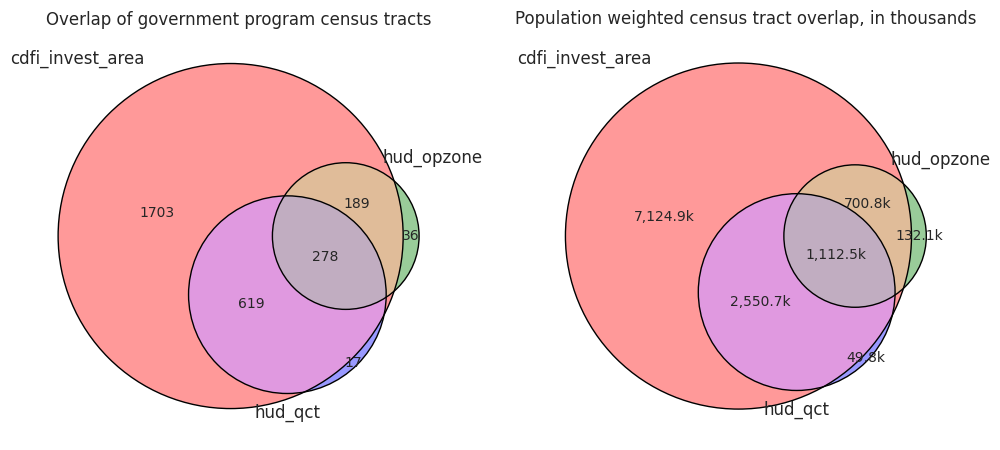

In [ ]:
labels=["cdfi_invest_area","hud_opzone","hud_qct"]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

d=df.loc[:,["venn_key","total_population"]].groupby("venn_key").count()["total_population"].to_dict()
ax=axes[0]

venn3(d, set_labels=labels, ax=ax)
venn3_circles(d, linewidth=1, ax=ax)
ax.set_title("Overlap of government program census tracts")

d=df.loc[:,["venn_key","total_population"]].groupby("venn_key").sum()["total_population"].to_dict()
ax=axes[1]

venn3(d, set_labels=labels, subset_label_formatter=lambda x: f"{x/1000:,.1f}k", ax=ax)
venn3_circles(d, linewidth=1, ax=ax)
ax.set_title("Population weighted census tract overlap, in thousands")

plt.show()




*cdfi_invest_area* - is the same as before

*hud_opzone* - is HUD Opportunity Zone census tracts. This is the "opzone" field in the EODataScape data dictionary, which says that the data is from 2018

*hud_qct*  - is HUD Low Income Housing Tax Credit (LIHTC) program Qualified Census Tracts. Field "qct" in EODataScape data dictionary, from 2025

Here we see that there are significantly more CDFI investment areas than their are HUD program census tracts, and that most HUD census tracts are also CDFI investment areas. There is also significant overlap between the set of HUD opzone and qct census tracts.

There are some HUD tracts that aren't CDFI investment areas. I haven't looked into whether that is due to the data coming from different years or from their different criteria, but there are relatively few of them.

The diagram on the left indicates the number of census tracts in each subset. (Florida has around 5000 census tracts, but many of those don't belong to any of these programs so are not represented in the diagram).

The diagram on the right gives the number of people in each subset (adding up the populations of the census tracts in each subset).

As we can see, the proportions in each diagram are about the same, so weighting by population doesn't change much.



---



Next, let's look at how the number of households, number of mortgages, and CDFI lending break down between these different programs. We'll make pie charts, so that we can include census tracts that don't belong to any of these programs.

Given that almost all HUD census tracts are also investment areas, we'll combine those that aren't into a single "other" pie slice for display purposes.

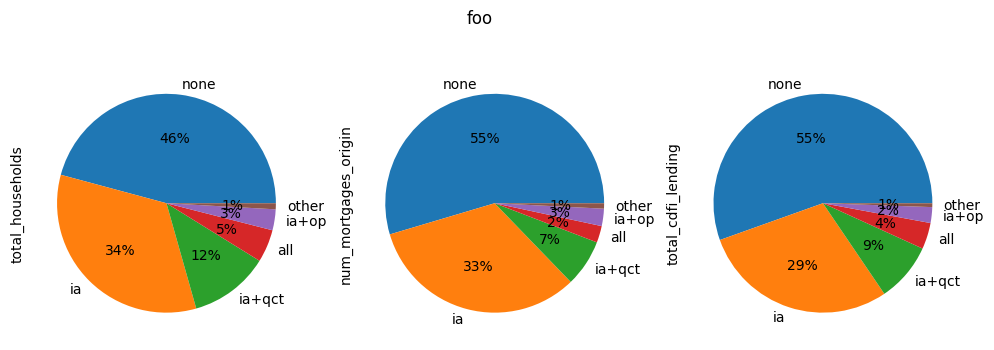

In [ ]:
a=df.loc[:,["overlap_label","total_households","num_mortgages_origin","total_cdfi_lending"]].groupby("overlap_label").sum()
a=a.sort_values("total_households",ascending=False)

a.plot.pie(subplots=True,autopct='%1.0f%%',legend=False,figsize=(12, 4),title="foo")
plt.show()

<Axes: ylabel='total_cdfi_lending'>

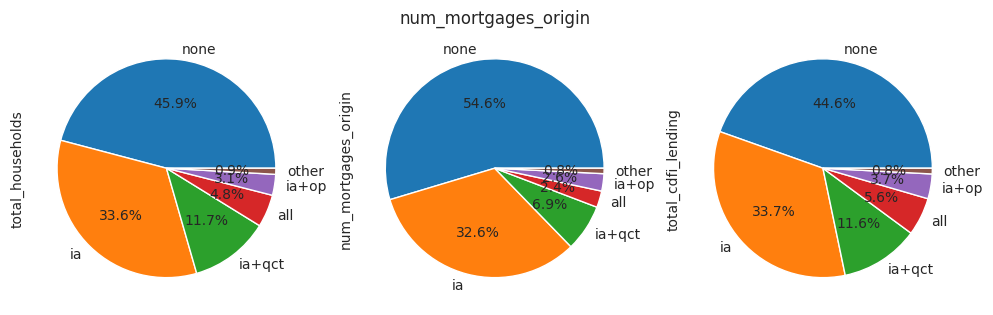

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

#labels=["none","cdfi","cdfi+qct","all","cdfi+opzone","other","other","other","other"]
a=df.loc[:,["overlap_label","total_households","num_mortgages_origin"]].groupby("overlap_label").sum()
a=a.sort_values("total_households",ascending=False)

#axes[0].pie(a.total_households,autopct='%1.1f%%',labels=a.index.astype(str))
a.plot.pie(y="total_households",ax=axes[0],autopct='%1.1f%%',labels=a.index,legend=False)

#axes[1].pie(a.num_mortgages_origin,autopct='%1.1f%%',labels=a.index)
a.plot.pie(y="num_mortgages_origin",ax=axes[1],autopct='%1.1f%%',labels=a.index,legend=False)
axes[1].set_title("num_mortgages_origin")

a=df.query("total_cdfi_lending<1000000").loc[:,["overlap_label","total_households","total_cdfi_lending"]].groupby("overlap_label").sum()
a=a.sort_values("total_households",ascending=False)

a.plot.pie(y="total_cdfi_lending",ax=axes[2],autopct='%1.1f%%',labels=a.index,legend=False)
#axes[2].pie(a.total_cdfi_lending,autopct='%1.1f%%',labels=a.index)

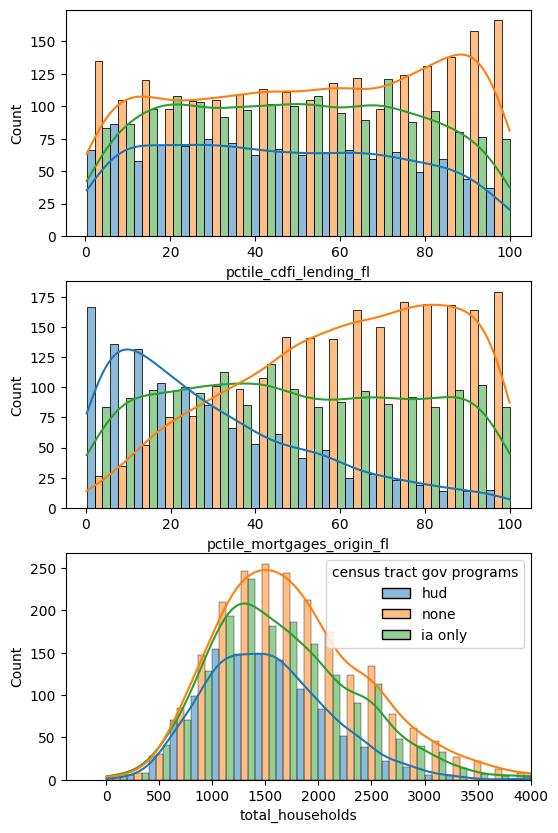

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 10))
ax=axes[0]
sns.histplot(
    data=df,
#    x="pov_pct_est",
    x="pctile_cdfi_lending_fl",
    hue="overlap_label2",
#    hue_order=["none","ia only","hud"],
#    hue_order=[True,False],
#    binrange=(0,100),
#    binwidth=0.05,
#    xlim=50,
    multiple="dodge",
    cumulative=False,
    kde=True,
    legend=False,
    ax=ax
#    element="step"
#    stat="percent"
)
#ax.set_xlim(xmax=50)

ax=axes[1]
sns.histplot(
    data=df,
    x="pctile_mortgages_origin_fl",
    hue="overlap_label2",
#    hue_order=[True,False],
#    binrange=(0,100),
#    binwidth=2,
#    xlim=50,
    multiple="dodge",
    cumulative=False,
    legend=False,
    kde=True,
    ax=ax
#    element="step"
#    stat="percent"
)
#ax.set_xlim(xmax=100)

ax=axes[2]
sns.histplot(
    data=df.rename(columns={'overlap_label2': 'census tract gov programs'}),
    x="total_households",
    hue="census tract gov programs",
#    hue_order=[True,False],
    binrange=(0,4000),
    binwidth=200,
#    xlim=50,
    multiple="dodge",
    cumulative=False,
    kde=True,
    ax=ax
#    element="step"
#    stat="percent"
)
ax.set_xlim(xmax=4000)
"""
sns.histplot(
    data=df[df.pov_pct_est>=0],
    x="pov_pct_est",
    hue="overlap_label2",
#    hue_order=[True,False],
    binrange=(0,100),
    binwidth=2,
    multiple="layer",
    cumulative=False,
    kde=True,
    ax=ax
#    element="step"
#    stat="percent"
)
ax.set_xlim(xmin=0,xmax=50)
"""
plt.show()

In [ ]:

display("dropping rows with unknown demographics")
display(df.shape)
df.drop(df[df.pov_white_nh_pct_est<0].index,inplace=True)
df.drop(df[df.pov_pct_est<0].index,inplace=True)
df.drop(df[df.pop_pct_white<0].index,inplace=True)

display(df.shape)

display("adding columns for non-white and poor populations")

df["pop_pct_nonwhite"]=100-df.pop_pct_white
df["pov_nonwhite_pct_est"]=df.apply(
    lambda x: 0 if x.pov_white_nh_pct_est>=x.pov_pct_est else (x.pov_pct_est-x.pov_white_nh_pct_est),
    axis=1)
df["non_white_population"]=((100-df.pop_pct_white)*df.total_population//100)
df["poor_population"]=((100-df.pov_pct_est)*df.total_population//100)
df["poor_non_white_population"]=df.apply(
    lambda x: 0 if x.pov_white_nh_pct_est>=x.pov_pct_est else (x.pov_pct_est-x.pov_white_nh_pct_est)*x.total_population/100,
    axis=1)


'dropping rows with unknown demographics'

(5011, 396)

(4988, 396)

'adding columns for non-white and poor populations'

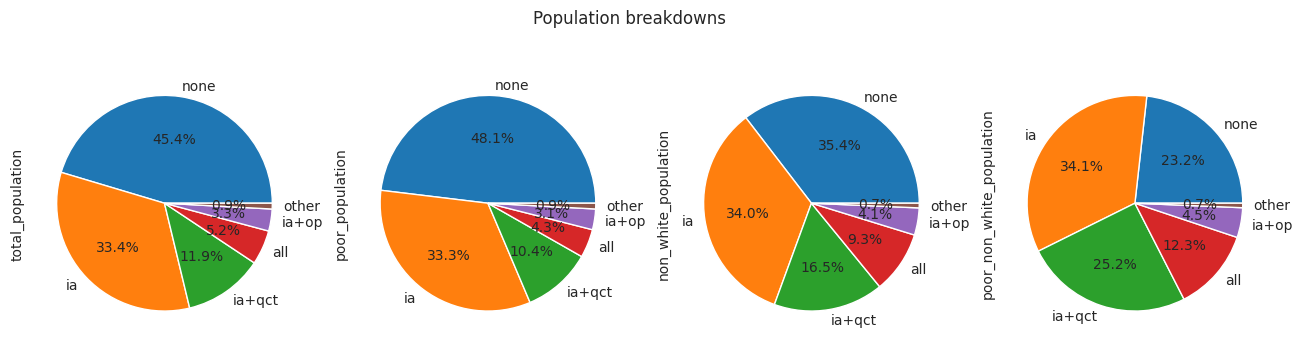

In [ ]:

sns.set_style("whitegrid")
#fig, axes = plt.subplots(1, 3, figsize=(16, 4))

a=df.loc[:,["overlap_label","total_population","poor_population","non_white_population","poor_non_white_population"]].groupby("overlap_label").sum()
a=a.sort_values("total_population",ascending=False)
a.plot.pie(subplots=True,autopct='%1.1f%%',legend=False,figsize=(16, 4),title="Population breakdowns")
plt.show()

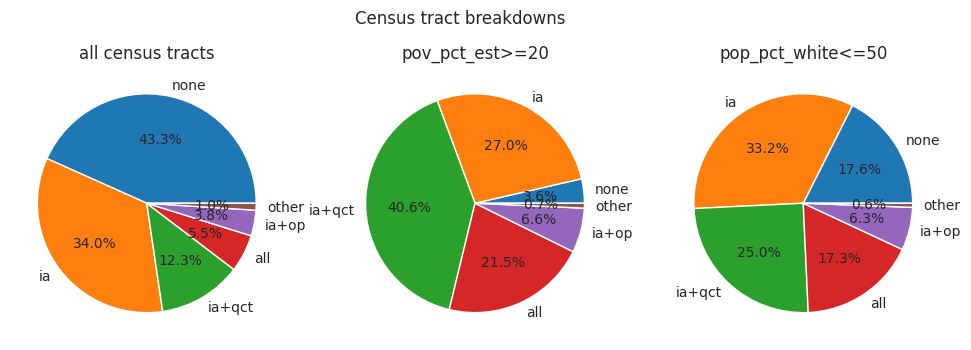

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Census tract breakdowns")

# plot total population pie chart
a=df.loc[:,["overlap_label","total_population"]].groupby("overlap_label").count().sort_values("total_population",ascending=False)
axes[0].pie(a.total_population,autopct='%1.1f%%',labels=a.index)
axes[0].set_title("all census tracts")

# make dataframe with ordering used in pie chart, so we can make the others have the same order
odf=pd.DataFrame(range(0,a.shape[0]), index=a.index, columns=["id"])

for i,qstr in enumerate(["pov_pct_est>=20","pop_pct_white<=50"]):
  a=df.query(qstr).loc[:,["overlap_label","total_population"]].groupby("overlap_label").count().join(odf).sort_values("id",ascending=True)
  axes[i+1].pie(a.total_population,autopct='%1.1f%%',labels=a.index)
  axes[i+1].set_title(qstr)

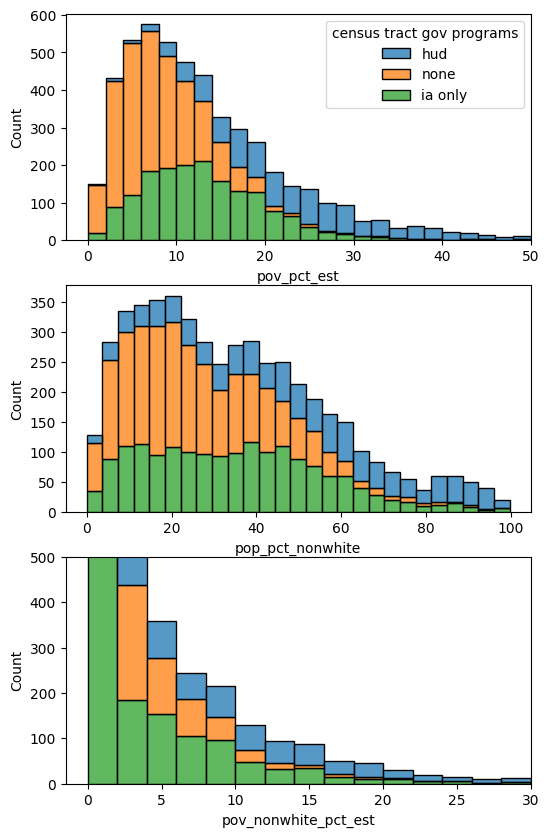

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 10))
ax=axes[0]
sns.histplot(
    data=df[df.pov_pct_est>=0].rename(columns={'overlap_label2': 'census tract gov programs'}),
    x="pov_pct_est",
#    x="pctile_cdfi_lending_fl",
    hue="census tract gov programs",
#    hue_order=["none","ia only","hud"],
#    hue_order=[True,False],
     binrange=(0,50),
    binwidth=2,
#    xlim=50,
    multiple="stack",
#    kde=True,
    legend=True,
    ax=ax
#    element="step"
#    stat="percent"
)
ax.set_xlim(xmax=50)

ax=axes[1]
sns.histplot(
    data=df[df.pop_pct_white>=0],
    x="pop_pct_nonwhite",
    hue="overlap_label2",
#    hue_order=[True,False],
#    binrange=(0,100),
#    binwidth=2,
#    xlim=50,
    multiple="stack",
    legend=False,
#    kde=True,
    ax=ax
#    element="step"
#    stat="percent"
)
#ax.set_xlim(xmax=100)

ax=axes[2]
sns.histplot(
    data=df,
    x="pov_nonwhite_pct_est",
    hue="overlap_label2",
#    hue_order=[True,False],
    binrange=(0,30),
    binwidth=2,
#    xlim=50,
    multiple="stack",
#    kde=True,
    legend=False,
    ax=ax
#    element="step"
#    stat="percent"
)
ax.set_xlim(xmax=30)
ax.set_ylim(ymax=500)
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 10))
ax=axes[0]
sns.histplot(
    data=df,
    x="pov_pct_est",
#    x="pctile_cdfi_lending_fl",
    hue="overlap_label2",
#    hue_order=["none","ia only","hud"],
#    hue_order=[True,False],
#    binrange=(0,100),
#    binwidth=0.05,
#    xlim=50,
    multiple="layer",
    kde=True,
    legend=False,
    ax=ax
#    element="step"
#    stat="percent"
)
#ax.set_xlim(xmax=50)

ax=axes[1]
sns.histplot(
    data=df,
    x="pop_pct_white",
    hue="overlap_label2",
#    hue_order=[True,False],
#    binrange=(0,100),
#    binwidth=2,
#    xlim=50,
    multiple="dodge",
    cumulative=False,
    legend=False,
    kde=True,
    ax=ax
#    element="step"
#    stat="percent"
)
#ax.set_xlim(xmax=100)

ax=axes[2]
sns.histplot(
    data=df.rename(columns={'overlap_label2': 'census tract gov programs'}),
    x="total_households",
    hue="census tract gov programs",
#    hue_order=[True,False],
#    binrange=(0,100),
#    binwidth=2,
#    xlim=50,
    multiple="dodge",
    cumulative=False,
    kde=True,
    ax=ax
#    element="step"
#    stat="percent"
)
#ax.set_xlim(xmax=5000)

plt.show()

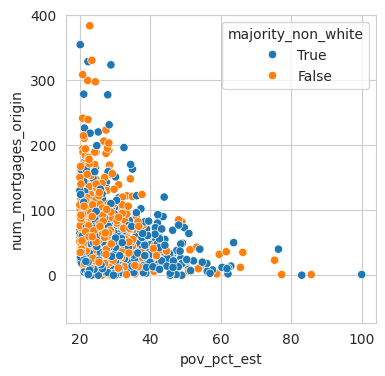

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
df["majority_non_white"]=df.pop_pct_white.apply(lambda x: x<50)
sns.scatterplot(df.query("pov_pct_est>20"),x="pov_pct_est",y="num_mortgages_origin",hue="majority_non_white",hue_order=[True,False],ax=ax)
ax.set_ylim(ymax=400)
plt.show()
#

Text(0.5, 1.0, 'Tracts with high poverty rate')

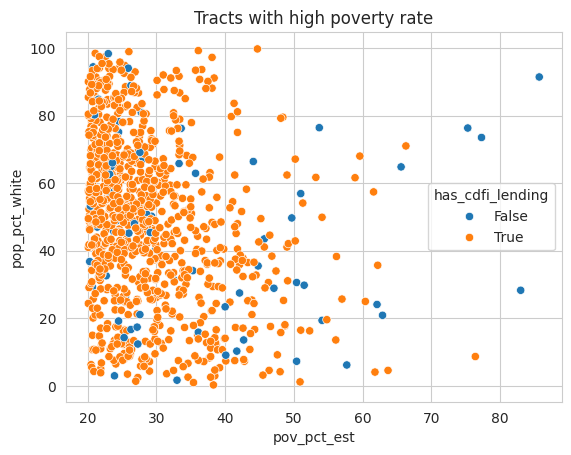

In [ ]:
sns.set_style("whitegrid")
sns.scatterplot(df.query("pov_pct_est>20"),x="pov_pct_est",y="pop_pct_white",hue="has_cdfi_lending") #hue="cdfi_fund_invest_areas")
plt.title("Tracts with high poverty rate")

Text(0.5, 1.0, 'Tracts with negligible CDFI lending')

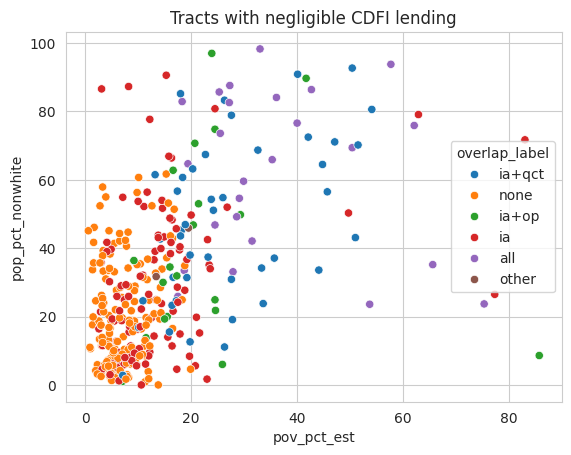

In [ ]:
sns.set_style("whitegrid")
#df["pop_pct_nonwhite"]=100-df.pop_pct_white
sns.scatterplot(df[df.has_cdfi_lending==0],x="pov_pct_est",y="pop_pct_nonwhite",hue="overlap_label") #hue="cdfi_fund_invest_areas")
plt.title("Tracts with negligible CDFI lending")

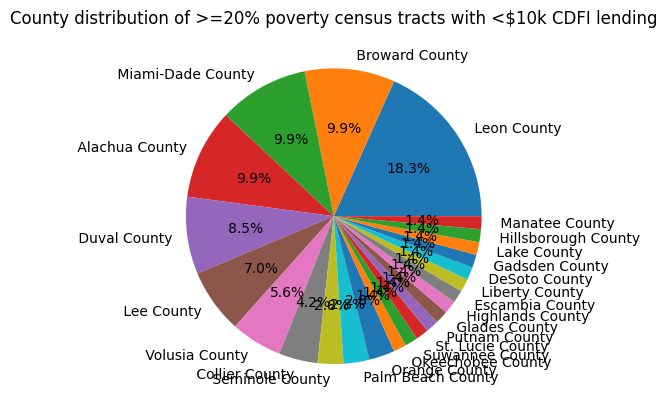

In [ ]:

cdf=df.query("has_cdfi_lending==0 and pov_pct_est>=20").loc[:,["total_population","county_name"]].groupby("county_name").count().sort_values("total_population",ascending=False)
#percent_cdfi_funding_in_top_1_percent = df.total_cdfi_lending[df.total_cdfi_lending>=q.loc[0.99,"total_cdfi_lending"]].sum()*100/df.total_cdfi_lending.sum()

fig, ax = plt.subplots()

plt.pie(cdf.total_population,autopct='%1.1f%%',labels=cdf.index)
#venn3(a["total_households"].apply(lambda x: x/1000).to_dict(),set_labels=labels,ax=ax)
plt.title("County distribution of >=20% poverty census tracts with <$10k CDFI lending")
plt.show()


<Axes: xlabel='pov_pct_est', ylabel='pctile_cdfi_lending_fl'>

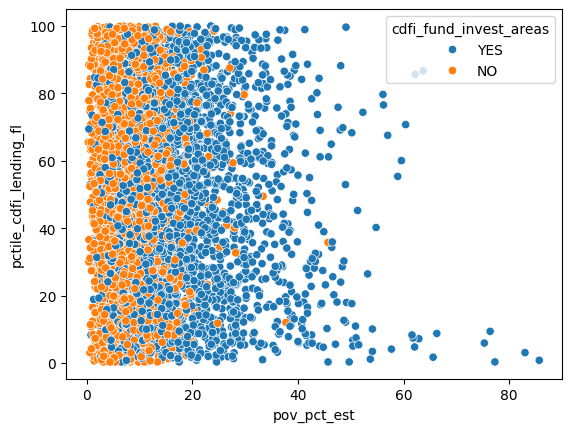

In [ ]:
sns.scatterplot(df[df.pov_pct_est>0],x="pov_pct_est",y="pctile_cdfi_lending_fl",hue="cdfi_fund_invest_areas")


In [ ]:
pd.crosstab(tdf.pctile_cdfi_lending_fl,tdf.pov_pct_est)

pov_pct_est,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,61.0,62.0,63.0,65.0,66.0,75.0,76.0,77.0,83.0,85.0
pctile_cdfi_lending_fl,,,,,,,,,,,,,,,,,,,,,
0.0,0,1,1,3,6,6,6,5,2,1,...,0,0,0,0,0,0,0,1,0,1
1.0,0,1,3,5,3,2,3,4,5,2,...,0,0,0,1,0,0,0,0,0,0
2.0,0,1,1,3,3,3,3,0,4,4,...,0,0,0,0,0,0,0,0,0,0
3.0,1,0,2,2,3,2,5,1,1,2,...,0,0,0,0,0,0,0,0,1,0
4.0,1,1,2,1,6,2,1,5,2,5,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96.0,0,0,2,1,3,7,6,1,5,1,...,0,0,0,0,0,0,0,0,0,0
97.0,0,3,1,2,8,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
98.0,0,2,2,2,3,2,5,4,4,2,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
tdf.iloc[:,1]

,pop_pct_nonwhite
0,90.0
1,30.0
2,20.0
3,20.0
4,50.0
...,...
5006,20.0
5007,10.0
5008,0.0
5009,20.0


<Axes: xlabel='pov_pct_est', ylabel='num_mortgages_origin'>

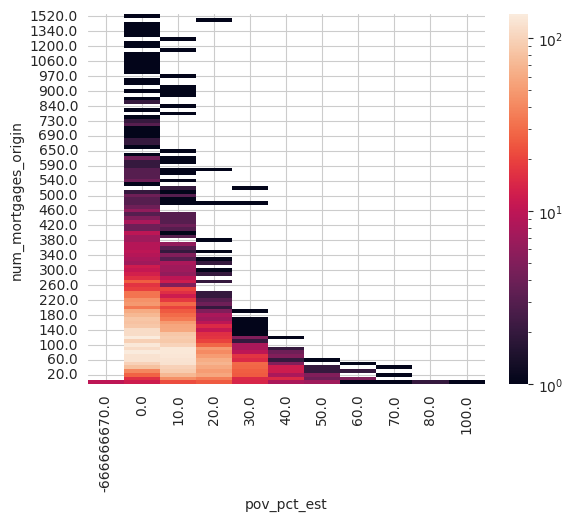

In [ ]:
import matplotlib.colors as colors

#tdf=df.loc[:,["pov_pct_est","pctile_cdfi_lending_fl"]].map(lambda x: (x//5)*5)
#tdf=df.loc[:,["pov_pct_est","pop_pct_nonwhite"]].map(lambda x: (x//10)*10)
tdf=df.loc[:,["pov_pct_est","num_mortgages_origin"]].map(lambda x: (x//10)*10)

#ct=pd.crosstab(tdf.pctile_cdfi_lending_fl,tdf.pov_pct_est)
#ct.sort_index(ascending=False,inplace=False)
#ct.sort_index(axis=1,ascending=False,inplace=True)

sns.heatmap(pd.crosstab(tdf.iloc[:,1],tdf.iloc[:,0]).sort_index(ascending=False),norm=colors.LogNorm())

In [ ]:
EJScreen_columns_base_dict={
    "traffic_prox" : "traffic_prox",
    "haz_waste_prox" : "haz_waste_prox",
    "air_toxics_cancer" : "air_toxics_cancer",
}


In [ ]:
sns.histplot(data=df[df.traffic_prox_pctile<=90],x="traffic_prox",hue="overlap_label2",multiple="dodge")

In [ ]:

df["flood_risk_30yr_share"]=df["flood_risk_30yr_share"].map(lambda x: 100 if x>100 else x)
df["fire_risk_30yr_share"]=df["fire_risk_30yr_share"].map(lambda x: 100 if x>100 else x)


In [ ]:
df.rename(columns={
    'flood_risk_30yr_pctile': 'flood_risk_30yr_share_pctile',
    'fire_risk_30yr_pctile': 'fire_risk_30yr_share_pctile'
    },inplace=True)
# drop impossible values
display("dropping rows with impossible fire or flood shares")
display(df.shape)
df.drop(df[df.flood_risk_30yr_share>100].index,inplace=True)
df.drop(df[df.fire_risk_30yr_share>100].index,inplace=True)
display(df.shape)

#df["flood_risk_30yr_share"]=df["flood_risk_30yr_share"].map(lambda x: 100 if x>100 else x)
#df["fire_risk_30yr_share"]=df["fire_risk_30yr_share"].map(lambda x: 100 if x>100 else x)

# make buckets
df["mortgages_pctile_bucket"]=df.pctile_mortgages_origin_fl.apply(lambda x: 0 if x< 50 else (50 if x<90 else 90))
df["cdfi_lending_pctile_bucket"]=df.pctile_cdfi_lending_fl.apply(lambda x: 0 if x< 50 else (50 if x<90 else 90))
for col in ["traffic_prox_pctile", "haz_waste_prox_pctile","air_toxics_cancer_pctile","flood_risk_30yr_share_pctile","fire_risk_30yr_share_pctile"]:
    df[f"{col}_bucket"]=df[col].apply(lambda x: 0 if x< 50 else (50 if x<90 else 90))

'dropping rows with impossible fire or flood shares'

(4988, 401)

(4938, 401)

<Axes: xlabel='traffic_prox', ylabel='Count'>

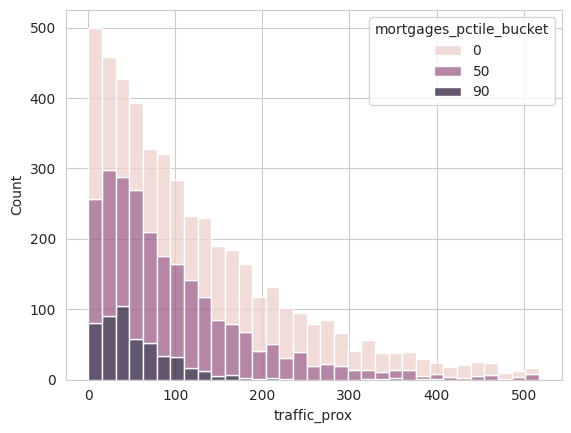

In [ ]:
sns.histplot(data=df[df.traffic_prox_pctile<=90],x="traffic_prox",hue="mortgages_pctile_bucket",multiple="stack") #,binrange=(0,2),multiple="stack",stat="percent")

<Axes: xlabel='traffic_prox', ylabel='Count'>

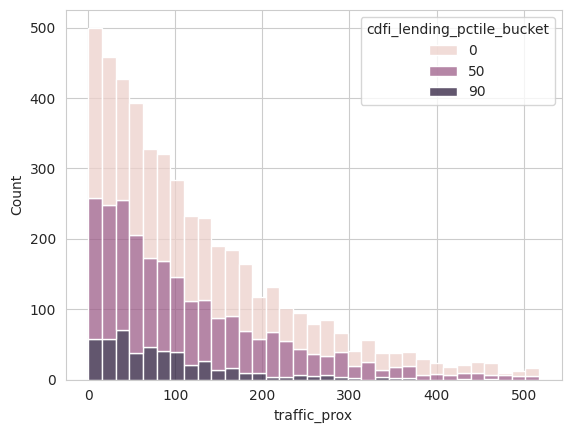

In [ ]:
sns.histplot(data=df[df.traffic_prox_pctile<=90],x="traffic_prox",hue="cdfi_lending_pctile_bucket",multiple="stack") #,binrange=(0,2),multiple="stack",stat="percent")

<Axes: xlabel='num_mortgages_origin', ylabel='Count'>

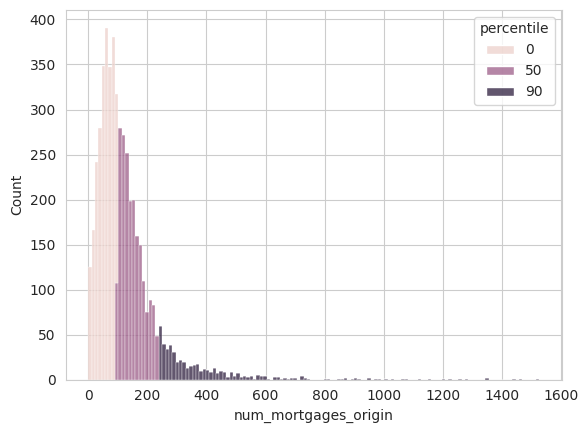

In [ ]:
#col="traffic_prox"
#pctile_col="traffic_prox_pctile"
#pctile_col="pctile_cdfi_lending_fl"
#col="total_cdfi_lending"
pctile_col="pctile_mortgages_origin_fl"
col="num_mortgages_origin"

tdf=df.loc[:,[col,pctile_col]]
tdf["percentile"]=tdf.loc[:,pctile_col].apply(lambda x: 0 if x< 50 else (50 if x<90 else 90))
sns.histplot(data=tdf,x=col,hue="percentile",multiple="stack") #,binrange=(0,2),multiple="stack",stat="percent")

<Axes: xlabel='pov_pct_est', ylabel='Count'>

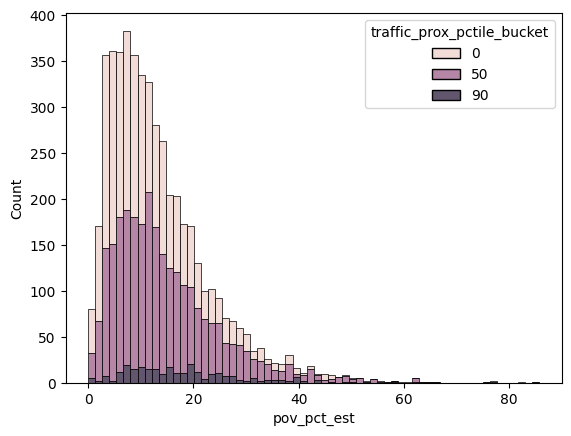

In [ ]:
sns.histplot(data=df,x="pov_pct_est",hue="traffic_prox_pctile_bucket",multiple="stack") #,binrange=(0,2),multiple="stack",stat="percent")traffic_prox_pctile

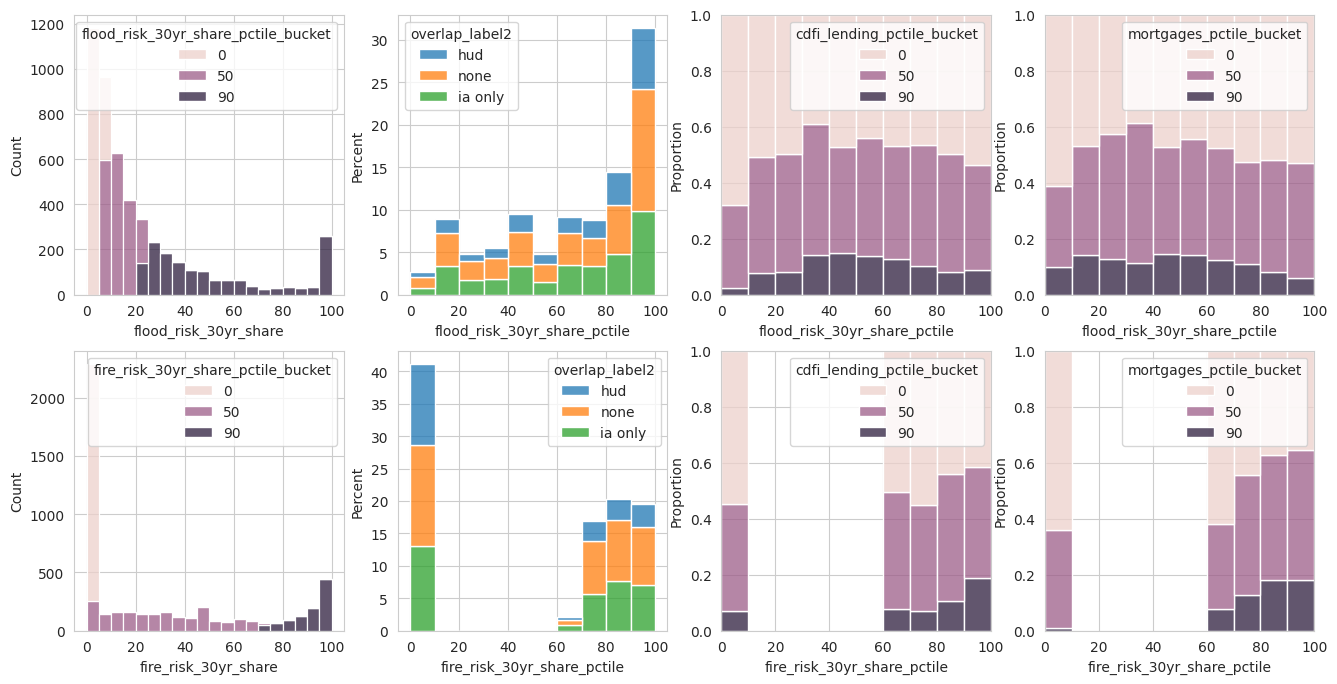

In [ ]:

sns.set_style("whitegrid")

cols=["flood_risk_30yr_share","fire_risk_30yr_share"]
hues=["overlap_label2","cdfi_lending_pctile_bucket","mortgages_pctile_bucket"]

ncols=len(hues)+1
nrows=len(cols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))


collim={
    "haz_waste_prox":{"xmax":15,"ymax":50},
    "traffic_prox":{"xmax":2000,"ymax":200},
    "air_toxics_cancer":{"xmax":200,"ymax":100},
    }
#col=cols[0]
for i, ax in enumerate(axes.flat):
  j=i//ncols
  k=i%ncols
  col=cols[j]
  if k==0:
    sns.histplot(data=df,x=col,hue=f"{col}_pctile_bucket",multiple="stack",binwidth=bw,ax=ax)
    """
    xmax=collim[col]["xmax"]
    bw=xmax/40
    sns.histplot(data=df,x=col,hue=f"{col}_pctile_bucket",multiple="stack",binrange=(0,xmax),binwidth=bw,ax=ax)
#    ax.set_ylim(ymax=collim[col]["ymax"])
#    ax.set_xlim(xmax=xmax)
"""
  elif k==1:
    sns.histplot(data=df,x=f"{col}_pctile",hue=hues[k-1],multiple="stack",binrange=(0,100),binwidth=10,stat="percent",ax=ax)
  else:
    sns.histplot(data=df,x=f"{col}_pctile",hue=hues[k-1],multiple="fill",binrange=(0,100),binwidth=10,stat="proportion",ax=ax)

plt.show()

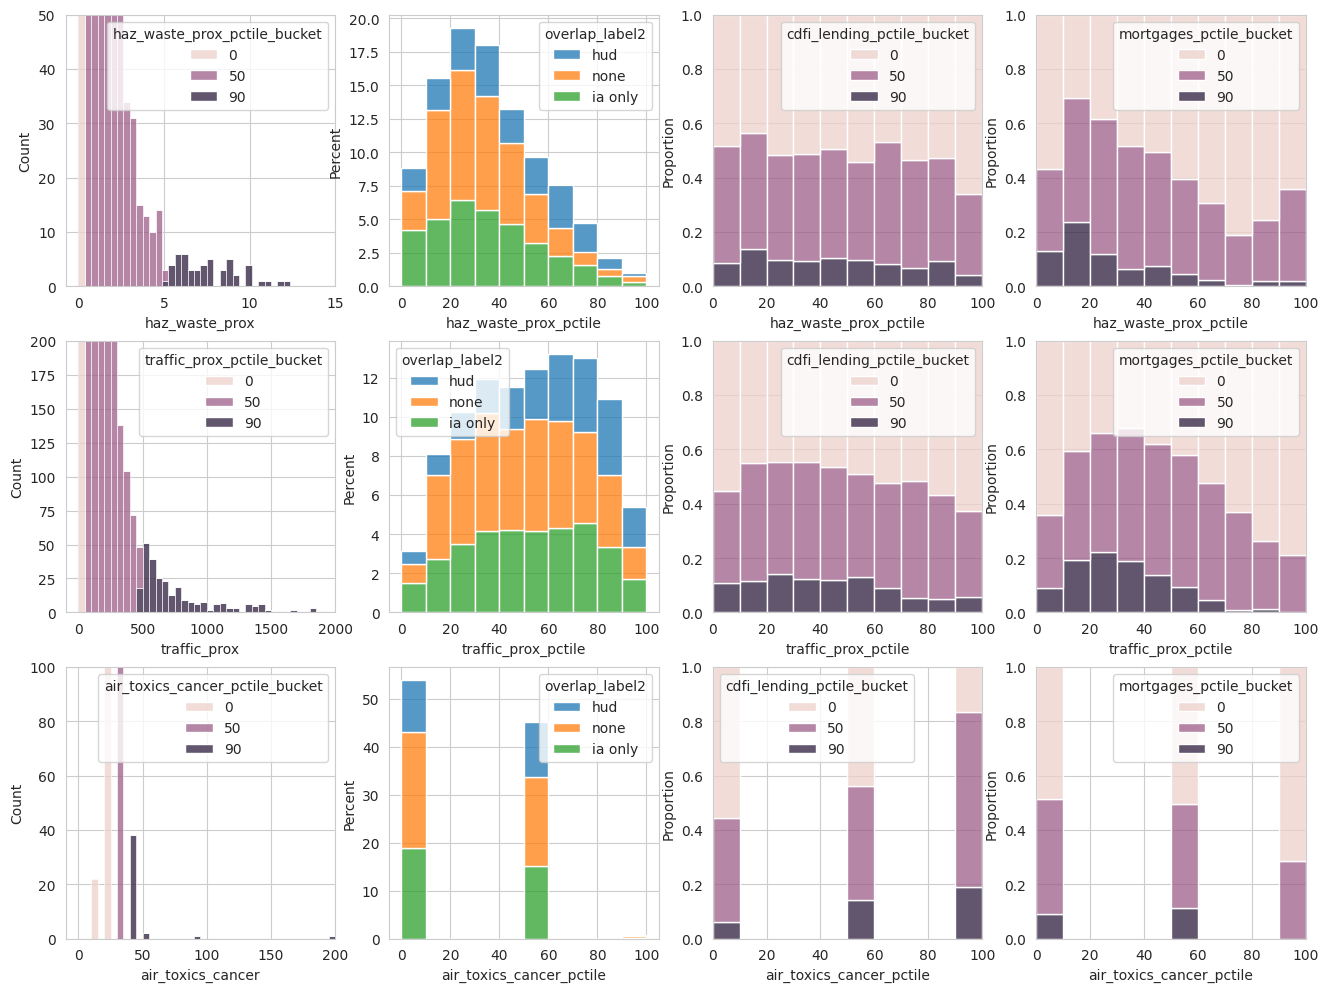

In [ ]:
#fig, axes = plt.subplots(2, 2, figsize=(8, 6))

sns.set_style("whitegrid")
cols=["haz_waste_prox","traffic_prox","air_toxics_cancer"]
hues=["overlap_label2","cdfi_lending_pctile_bucket","mortgages_pctile_bucket"]

ncols=len(hues)+1
nrows=len(cols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))


collim={
    "haz_waste_prox":{"xmax":15,"ymax":50},
    "traffic_prox":{"xmax":2000,"ymax":200},
    "air_toxics_cancer":{"xmax":200,"ymax":100},
    }
#col=cols[0]
for i, ax in enumerate(axes.flat):
  j=i//ncols
  k=i%ncols
  col=cols[j]
  if k==0:
    xmax=collim[col]["xmax"]
    bw=xmax/40
    sns.histplot(data=df,x=col,hue=f"{col}_pctile_bucket",multiple="stack",binrange=(0,xmax),binwidth=bw,ax=ax)
    ax.set_ylim(ymax=collim[col]["ymax"])
    ax.set_xlim(xmax=xmax)

  elif k==1:
    sns.histplot(data=df,x=f"{col}_pctile",hue=hues[k-1],multiple="stack",binrange=(0,100),binwidth=10,stat="percent",ax=ax)
  else:
    sns.histplot(data=df,x=f"{col}_pctile",hue=hues[k-1],multiple="fill",binrange=(0,100),binwidth=10,stat="proportion",ax=ax)

plt.show()

Discussion:
what raw data means
https://screeningtool.geoplatform.gov/en/methodology#flood-risk
How national percentiles compare to Florida
what happens to CDFI lending and mortgages at low and high percentiles

<Axes: xlabel='haz_waste_prox_pctile', ylabel='Percent'>

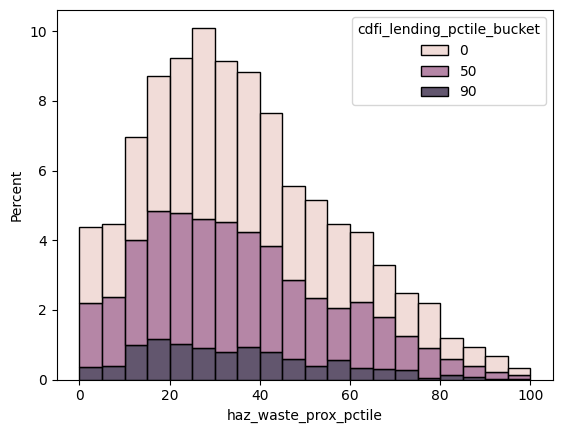

In [ ]:
sns.histplot(data=df,x="haz_waste_prox_pctile",hue="cdfi_lending_pctile_bucket",multiple="stack",binrange=(0,100),binwidth=5,stat="percent")

<Axes: xlabel='air_toxics_cancer_pctile', ylabel='Count'>

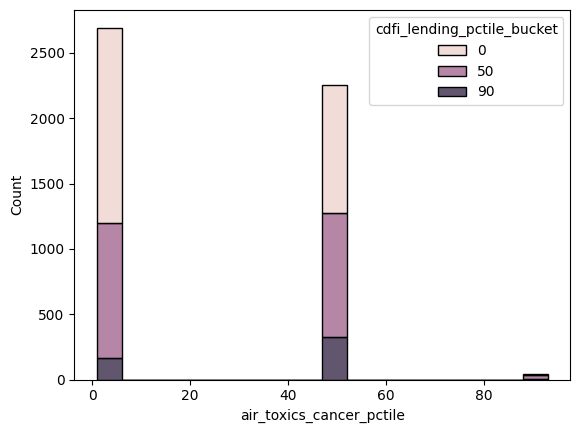

In [ ]:
sns.histplot(data=df,x="air_toxics_cancer_pctile",hue="cdfi_lending_pctile_bucket",multiple="stack")

<Axes: xlabel='traffic_prox_pctile', ylabel='Percent'>

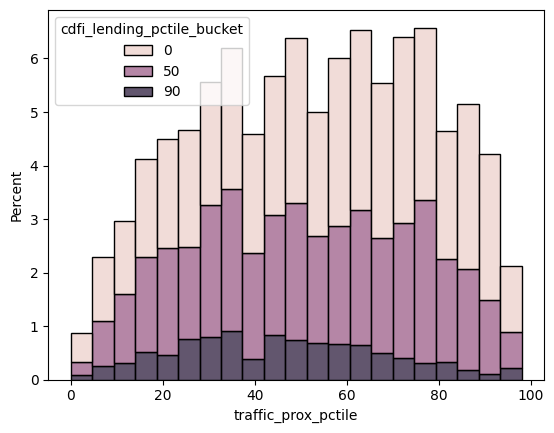

In [ ]:
sns.histplot(data=df,x="traffic_prox_pctile",hue="cdfi_lending_pctile_bucket",multiple="stack",stat="percent")